In [1]:
%%bash
wget http://curtis.ml.cmu.edu/datasets/hotpot/hotpot_dev_distractor_v1.json

--2025-06-23 03:35:35--  http://curtis.ml.cmu.edu/datasets/hotpot/hotpot_dev_distractor_v1.json
Resolving curtis.ml.cmu.edu (curtis.ml.cmu.edu)... 128.2.204.193
Connecting to curtis.ml.cmu.edu (curtis.ml.cmu.edu)|128.2.204.193|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46320117 (44M) [application/json]
Saving to: ‘hotpot_dev_distractor_v1.json’

     0K .......... .......... .......... .......... ..........  0%  396K 1m54s
    50K .......... .......... .......... .......... ..........  0%  795K 85s
   100K .......... .......... .......... .......... ..........  0% 82.9M 57s
   150K .......... .......... .......... .......... ..........  0% 38.0M 43s
   200K .......... .......... .......... .......... ..........  0%  809K 45s
   250K .......... .......... .......... .......... ..........  0% 86.9M 38s
   300K .......... .......... .......... .......... ..........  0% 22.7M 33s
   350K .......... .......... .......... .......... ..........  0% 63.3M 29s
   4

In [2]:
import pandas as pd

json_path='/kaggle/working/hotpot_dev_distractor_v1.json'

df=pd.read_json(json_path)
df.shape

(7405, 7)

In [3]:
# Shuffle the DataFrame and reset the index
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Select the first 1300 rows
df_shuffled.shape

(7405, 7)

In [4]:
def extract_contexts(supporting_facts, context_list):
    """
    supporting_facts: list of [entity_name, sent_idx], e.g. [['VIVA Media', 0], ...]
    context_list: list of [entity_name, [sent1, sent2, ...]], e.g. [['VIVA Media', [...]], ...]
    Returns: list of matched context sentences
    """
    evidence = []
    # Build a dict for fast lookup
    context_dict = {entity: sents for entity, sents in context_list}
    for entity, sent_idx in supporting_facts:
        if entity in context_dict:
            sents = context_dict[entity]
            if 0 <= sent_idx < len(sents):
                evidence.append(sents[sent_idx])
    return evidence

# Apply the function to the DataFrame
df_shuffled['evidence'] = df_shuffled.apply(
    lambda row: extract_contexts(row['supporting_facts'], row['context']),
    axis=1
)

df_shuffled.shape

(7405, 8)

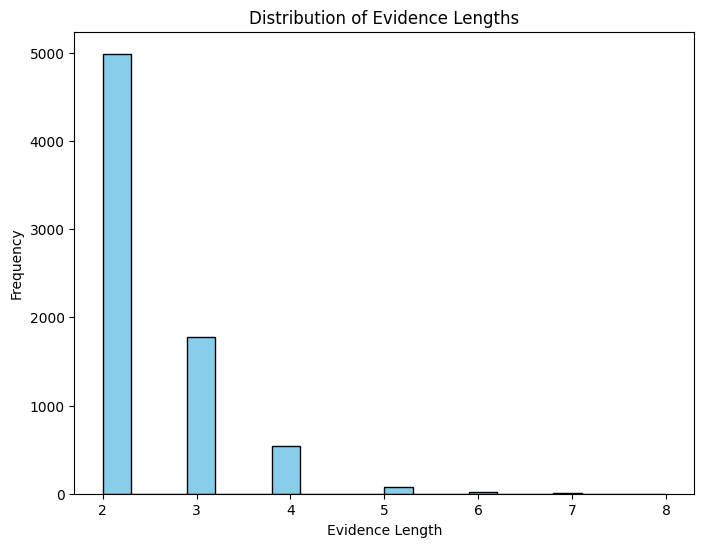

In [5]:
import matplotlib.pyplot as plt

# Calculate the length of each evidence list
evidence_lengths = df_shuffled['evidence'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Create a histogram of the lengths
plt.figure(figsize=(8, 6))
plt.hist(evidence_lengths, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Evidence Lengths')
plt.xlabel('Evidence Length')
plt.ylabel('Frequency')
plt.show()

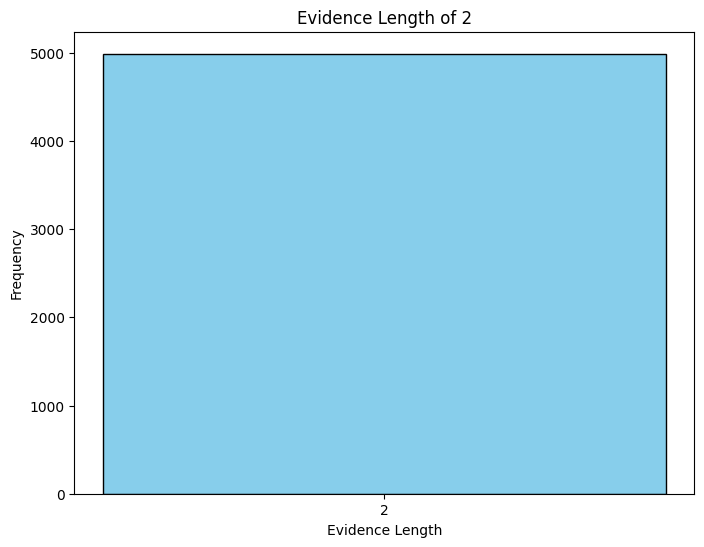

In [6]:
# Filter the dataframe to keep only rows where evidence length is 2
df_filtered = df_shuffled[df_shuffled['evidence'].apply(lambda x: len(x) == 2 if isinstance(x, list) else False)]

# Create a histogram of the filtered evidence lengths
evidence_lengths_filtered = df_filtered['evidence'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Create a histogram of the filtered evidence lengths
plt.figure(figsize=(8, 6))
plt.hist(evidence_lengths_filtered, bins=1, color='skyblue', edgecolor='black')
plt.title('Evidence Length of 2')
plt.xlabel('Evidence Length')
plt.ylabel('Frequency')
plt.xticks([2])  # Ensure the x-axis shows the length 2
plt.show()

In [7]:
df_filtered=df_filtered.drop(columns=['_id', 'supporting_facts', 'context', 'type', 'level']).head(1300)
df_filtered.shape

(1300, 3)

In [8]:
final_df=df_filtered.reset_index(drop=True)
final_df.shape

(1300, 3)

In [9]:
final_df.iloc[0].evidence

['VIVA Media GmbH (until 2004 "VIVA Media AG") is a music television network originating from Germany.',
 'A Gesellschaft mit beschränkter Haftung (] , abbreviated GmbH ] and also GesmbH in Austria) is a type of legal entity very common in Germany, Austria, Switzerland (where it is equivalent to a S.à r.l.) and Liechtenstein.']

In [10]:
import copy

def injected_irrelevant_content(evidence):
    irrelevant_content="This is irrelevant content"

    if len(evidence) == 2:
        evidence[1] = irrelevant_content
    return evidence

final_df['evidence_injected'] = final_df['evidence'].apply(copy.deepcopy)
final_df['evidence_injected'] = final_df['evidence_injected'].apply(injected_irrelevant_content)
final_df.shape

(1300, 4)

In [11]:
final_df.iloc[0].evidence_injected

['VIVA Media GmbH (until 2004 "VIVA Media AG") is a music television network originating from Germany.',
 'This is irrelevant content']

In [12]:
# Function to shuffle the two evidence items in the list
def shuffle_evidence(evidence):
    if isinstance(evidence, list):
        evidence.reverse()
    return evidence

final_df['evidence_shuffled'] = final_df['evidence'].apply(copy.deepcopy)
# Apply the shuffle function to the 'evidence' column
final_df['evidence_shuffled'] = final_df['evidence_shuffled'].apply(shuffle_evidence)

In [13]:
print(f"Original: {final_df.iloc[0].evidence}")
print(10*"=")
print(f"Injected: {final_df.iloc[0].evidence_injected}")
print(10*"=")
print(f"Shuffled: {final_df.iloc[0].evidence_shuffled}")
print(10*"=")
print(final_df.shape)

Original: ['VIVA Media GmbH (until 2004 "VIVA Media AG") is a music television network originating from Germany.', 'A Gesellschaft mit beschränkter Haftung (] , abbreviated GmbH ] and also GesmbH in Austria) is a type of legal entity very common in Germany, Austria, Switzerland (where it is equivalent to a S.à r.l.) and Liechtenstein.']
Injected: ['VIVA Media GmbH (until 2004 "VIVA Media AG") is a music television network originating from Germany.', 'This is irrelevant content']
Shuffled: ['A Gesellschaft mit beschränkter Haftung (] , abbreviated GmbH ] and also GesmbH in Austria) is a type of legal entity very common in Germany, Austria, Switzerland (where it is equivalent to a S.à r.l.) and Liechtenstein.', 'VIVA Media GmbH (until 2004 "VIVA Media AG") is a music television network originating from Germany.']
(1300, 5)


In [14]:
final_df.to_pickle('hotpotqa_injected_shuffled_all_in_one_df.pkl')

In [15]:
!rm -rf /kaggle/working/hotpot_dev_distractor_v1.json